In [3]:
!pip install scikit-network
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel, pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sknetwork.utils import get_membership
from sklearn.decomposition import TruncatedSVD
from IPython.display import SVG
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sknetwork.clustering import Louvain, get_modularity
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud

from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_dendrogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 30.2 MB/s eta 0:00:00


In [5]:

# Load the dataset
test = pd.read_csv("/content/test (2).csv")

# Initialize the tokenizer and model from the pre-trained 'philschmid/BERT-Banking77'
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', model=classification_model, tokenizer=tokenizer)

def get_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    normalized_embeddings = normalize(embeddings, axis=1, norm='l2')  # Normalize the embeddings
    return normalized_embeddings

# Apply the function to the 'text' column
test['embeddings'] = test['text'].apply(lambda x: get_bert_embeddings([x])[0])

# Show the DataFrame with embeddings
print(test[['text', 'embeddings']])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.95k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

                                                   text  \
0                              How do I locate my card?   
1     I still have not received my new card, I order...   
2     I ordered a card but it has not arrived. Help ...   
3      Is there a way to know when my card will arrive?   
4                          My card has not arrived yet.   
...                                                 ...   
3075      If i'm not in the UK, can I still get a card?   
3076                 How many countries do you support?   
3077              What countries do you do business in?   
3078             What are the countries you operate in.   
3079         Can the card be mailed and used in Europe?   

                                             embeddings  
0     [0.025442068, -0.03386337, 0.0026843003, 0.007...  
1     [0.010722405, 0.007851422, 0.07274575, -0.0132...  
2     [0.0123235015, -0.010357805, 0.07911538, 0.011...  
3     [-0.0020086144, -0.0009892675, 0.08350486, -0....  
4

In [6]:
# Convert embeddings to a matrix
embedding_matrix = np.vstack(test['embeddings'])

similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

similarity_matrix[similarity_matrix < 0.3] = 0

adjacency = csr_matrix(similarity_matrix)

Louvain

In [7]:
# Loop over a range of resolution parameters to find the one that optimze the modularity
best_resolution = 1.0
best_modularity = float('-inf')
best_labels = None # no clusters have been formed

for resolution in np.linspace(0.5, 2, 10):

    louvain = Louvain(resolution=resolution)
    labels = louvain.fit_predict(adjacency)
    modularity = get_modularity(adjacency, labels)

    if modularity > best_modularity:
        best_modularity = modularity
        best_resolution = resolution
        best_labels = labels

print("Best resolution parameter:", best_resolution)
print("Best modularity:", best_modularity)

Best resolution parameter: 1.0
Best modularity: 0.8148158307516962


In [8]:
# Apply the Louvain method
louvain = Louvain(resolution=1)
labels = louvain.fit_predict(adjacency)

In [9]:
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [369 242 227 204 201 163 163 159 155 125 121 121 121 120 119 116  82  74
  43  40  40  38  37]


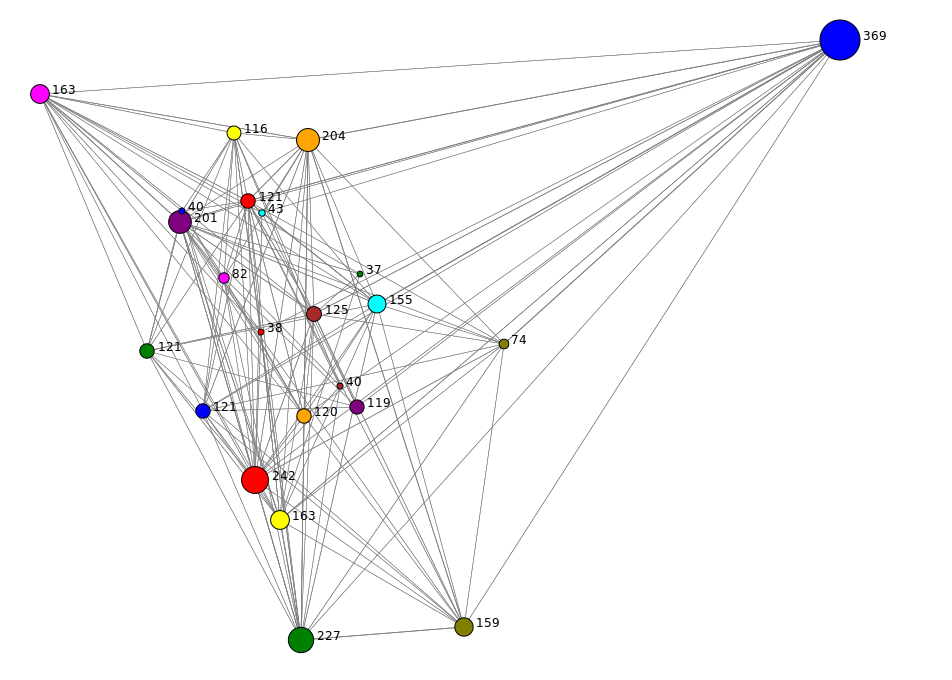

In [10]:
svd = TruncatedSVD(n_components=2)
position = svd.fit_transform(embedding_matrix)

adjacency_aggregate = louvain.aggregate_
average = normalize(get_membership(labels).T)

position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, position_aggregate, counts, labels=labels_unique,
                    display_node_weight=True, node_weights=counts, scale = 2)
SVG(image)

In [11]:
# Calculate modularity
get_modularity(adjacency, labels)

0.8148158307516962

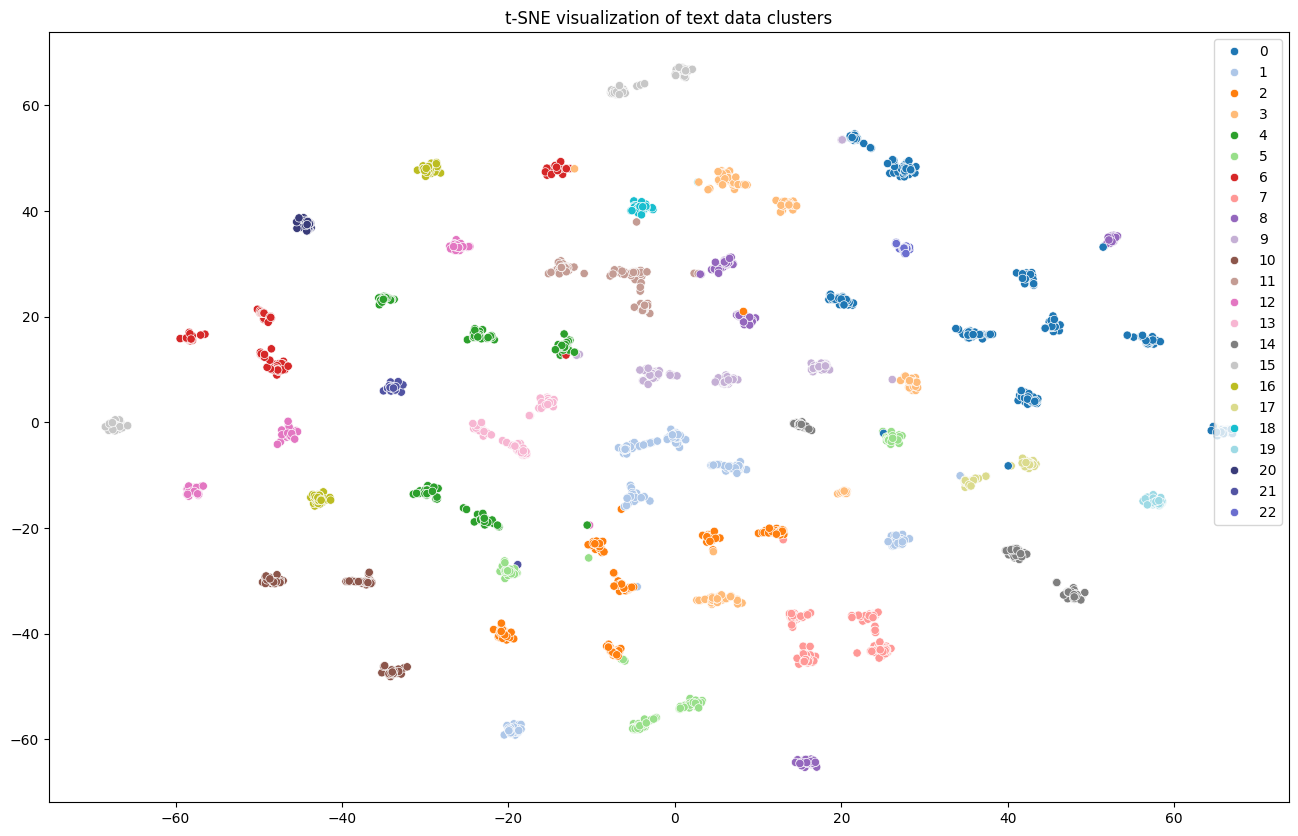

In [12]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embedding_matrix)

# Combine 'tab20' and 'tab20b' colormaps to get 40 distinct colors
tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
tab20b_colors = plt.cm.tab20b(np.linspace(0, 1, 20))
combined_colors = np.vstack((tab20_colors, tab20b_colors))
num_clusters = len(set(labels))
# Select the first 23 colors for palette
palette = combined_colors[:num_clusters]

plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels,
                palette=sns.color_palette(palette, num_clusters), legend="full")
plt.title('t-SNE visualization of text data clusters')
plt.show()


In [ ]:
# silhouette_avg = silhouette_score(embedding_matrix, labels)
# print("The average silhouette_score is :", silhouette_avg)

# # Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(embedding_matrix, labels)

# plt.figure(figsize=(10, 7))
# sns.distplot(sample_silhouette_values, bins=20, kde=True)
# plt.title('Silhouette Score Distribution')
# plt.xlabel('Silhouette Score')
# plt.ylabel('Density')
# plt.show()


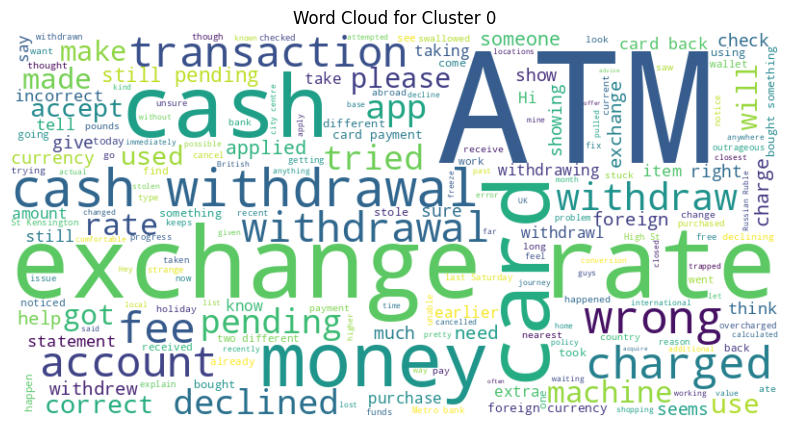

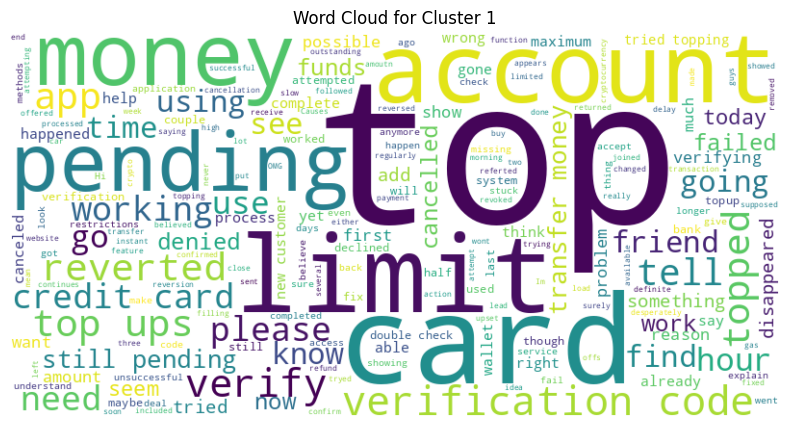

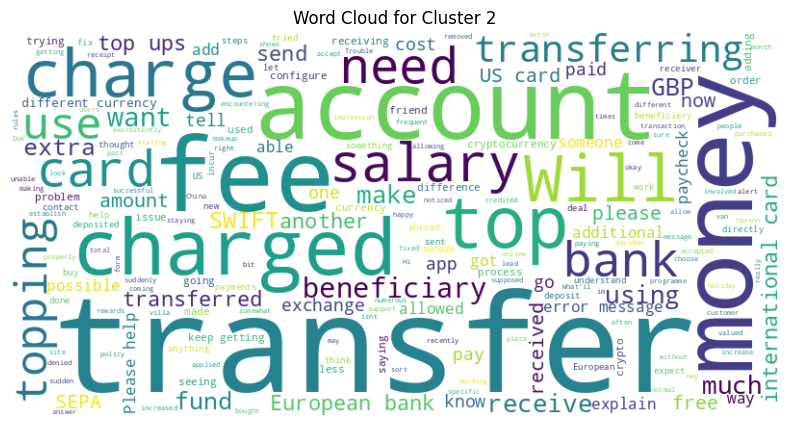

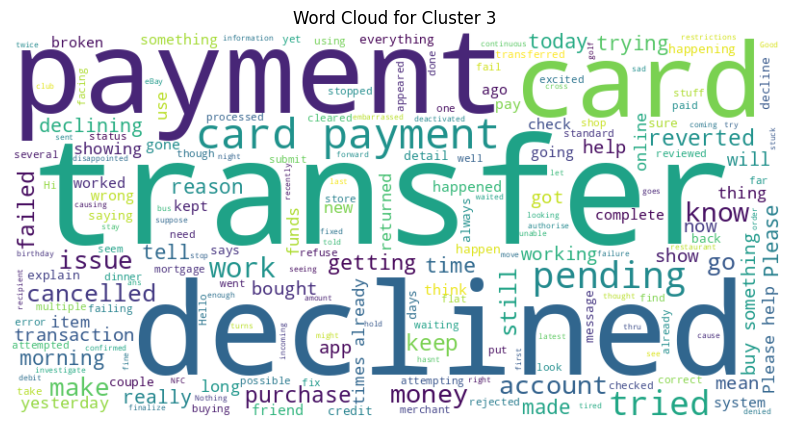

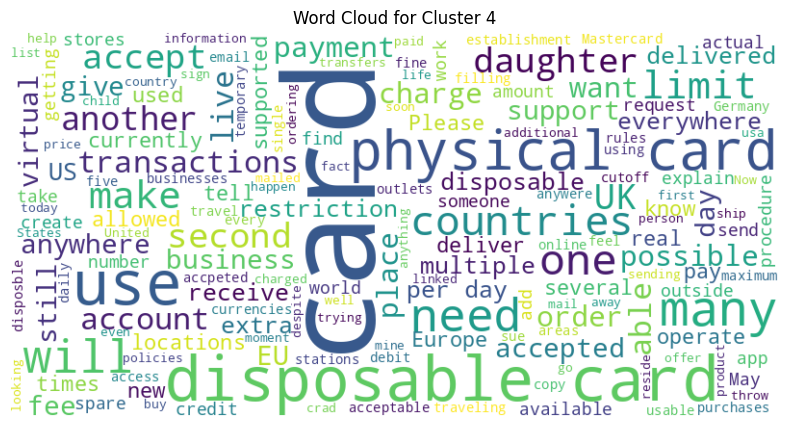

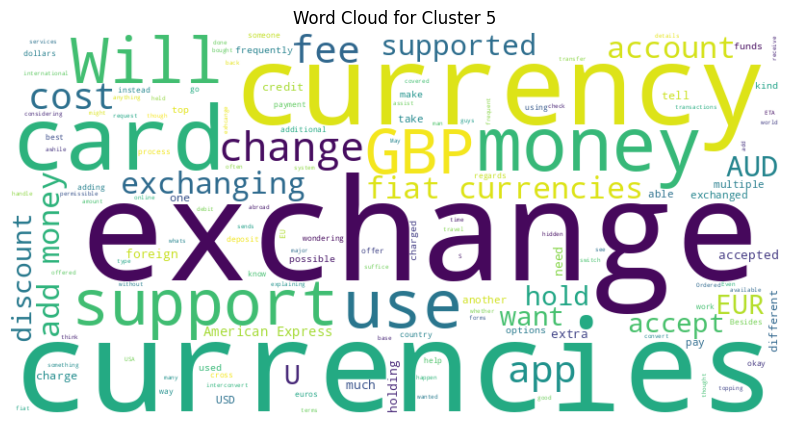

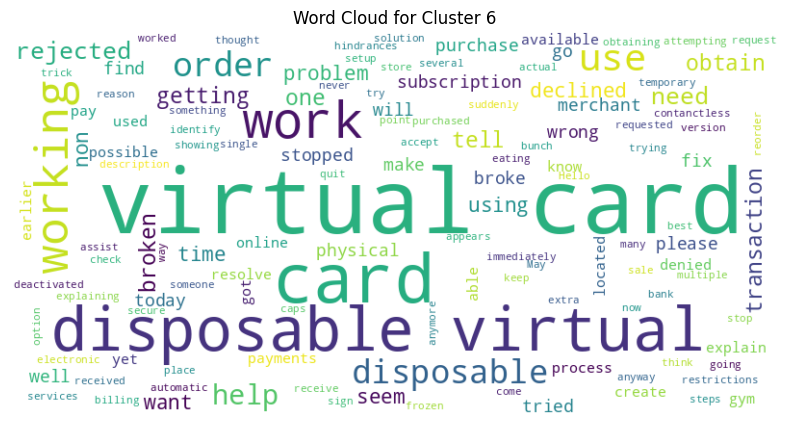

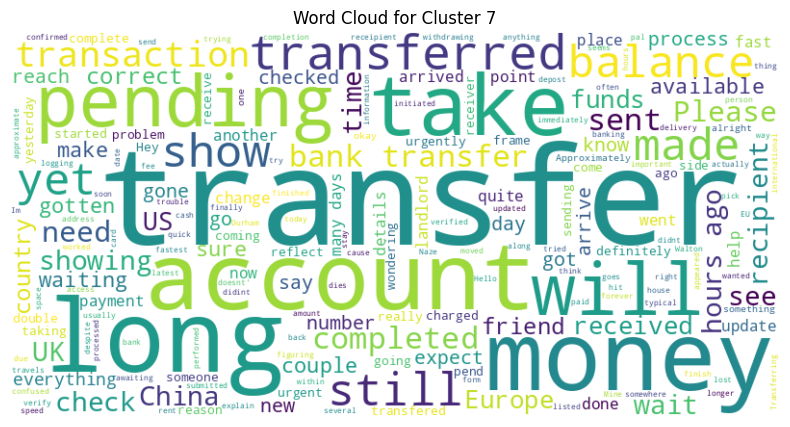

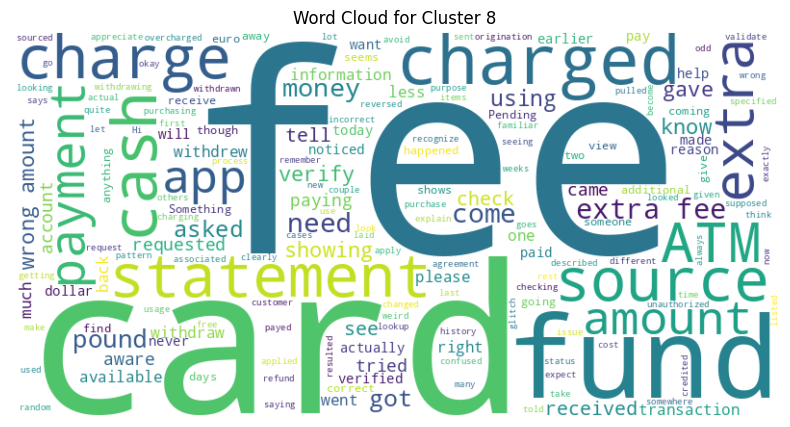

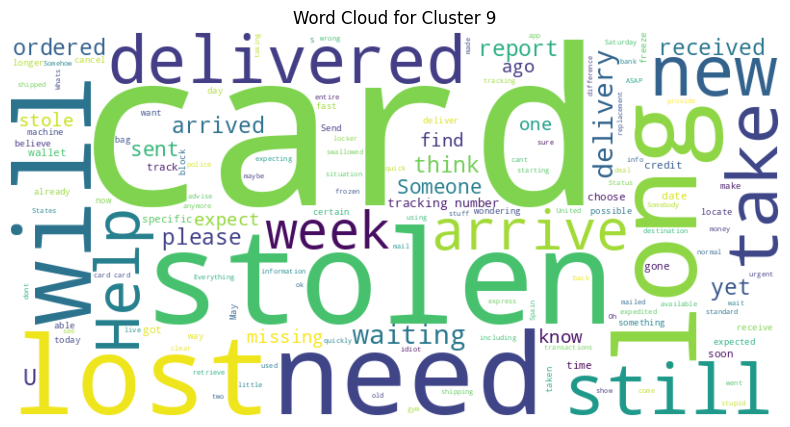

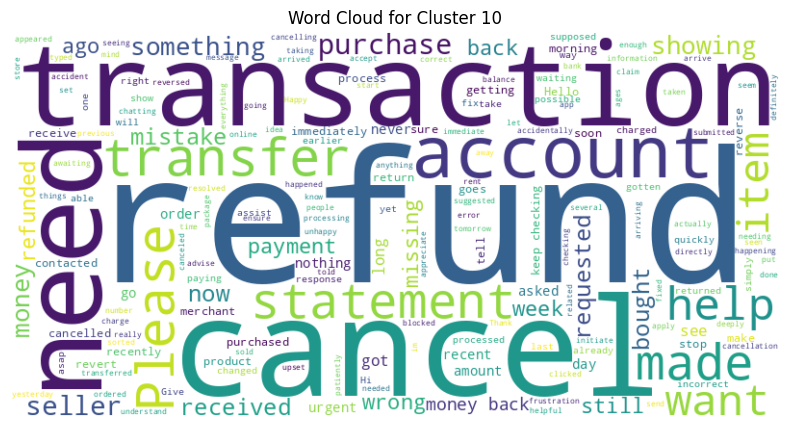

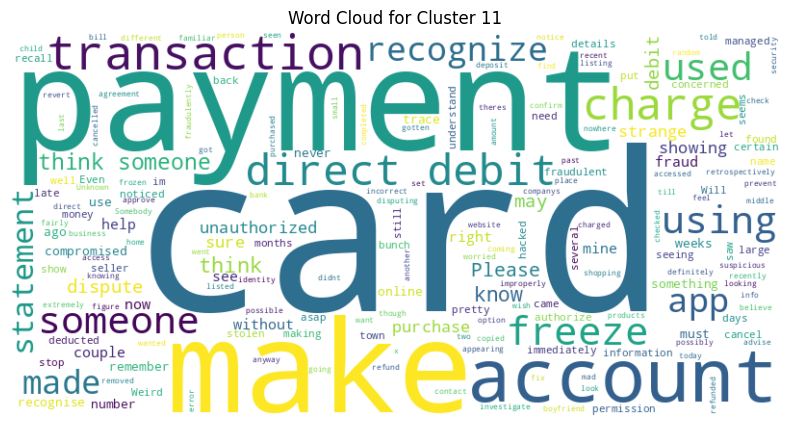

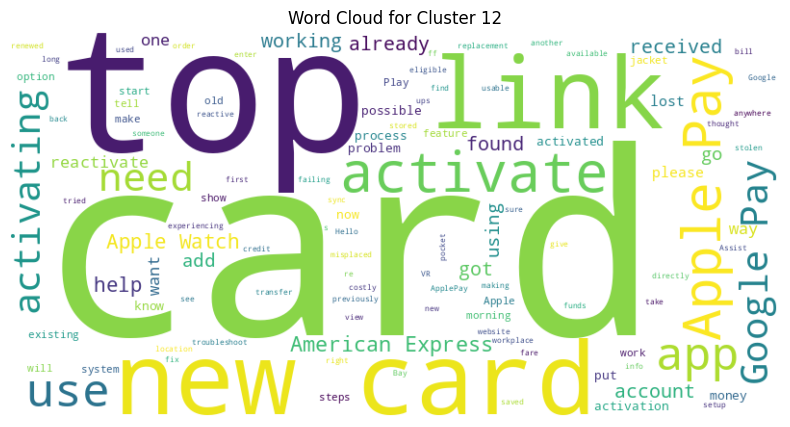

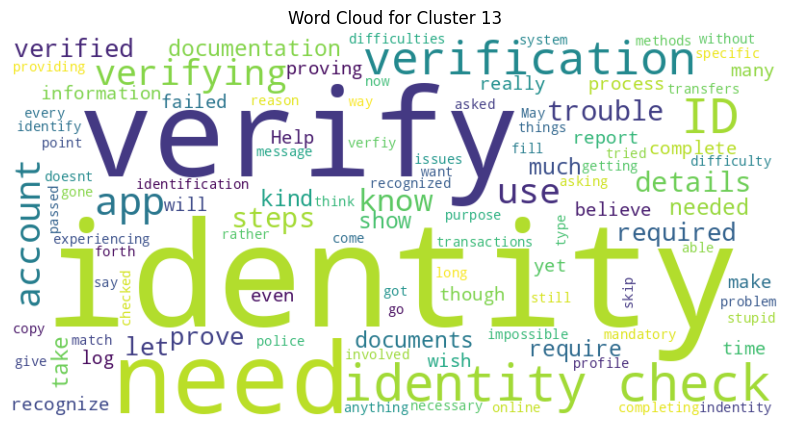

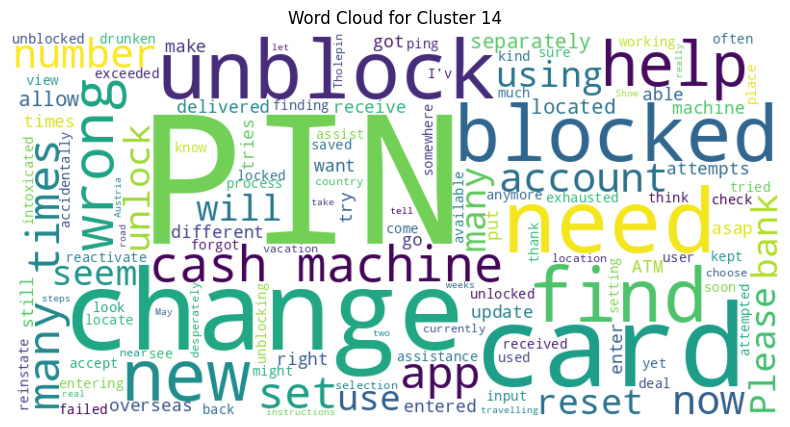

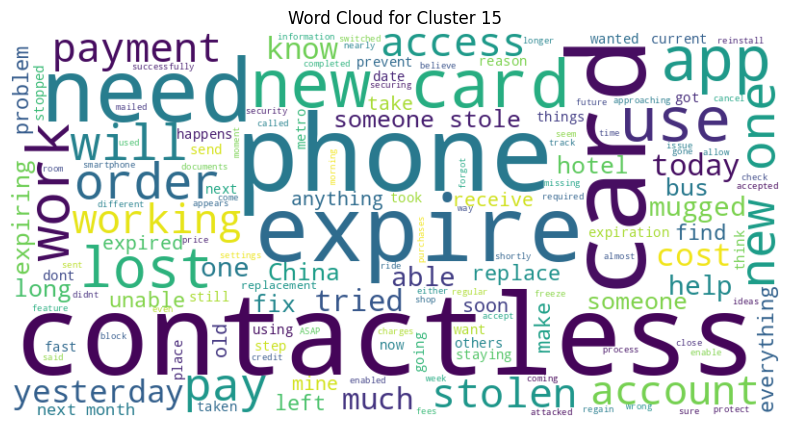

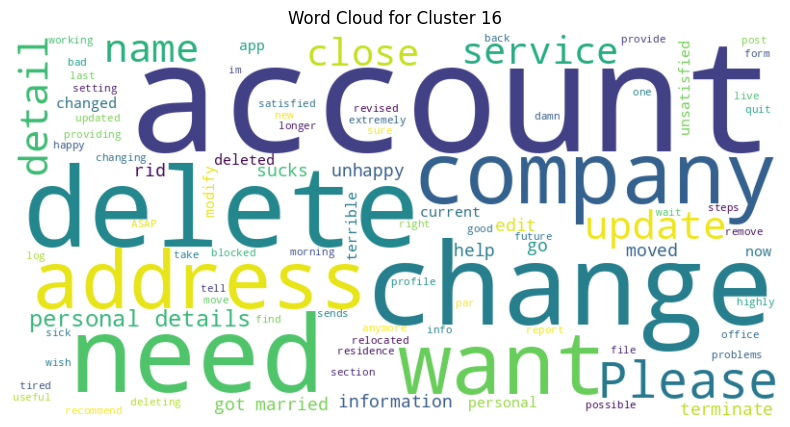

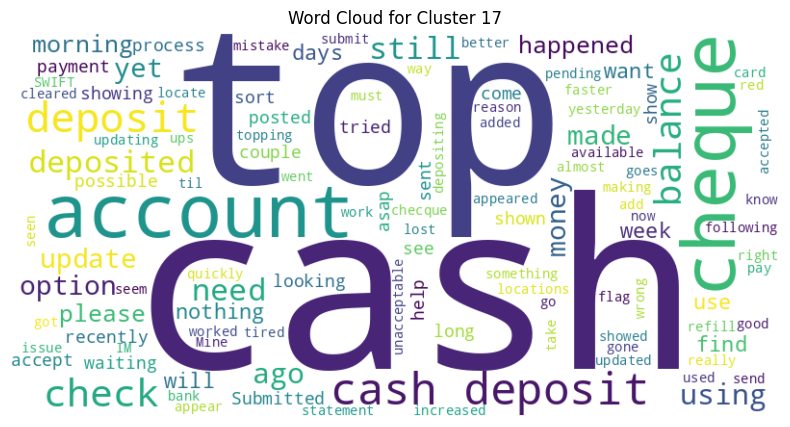

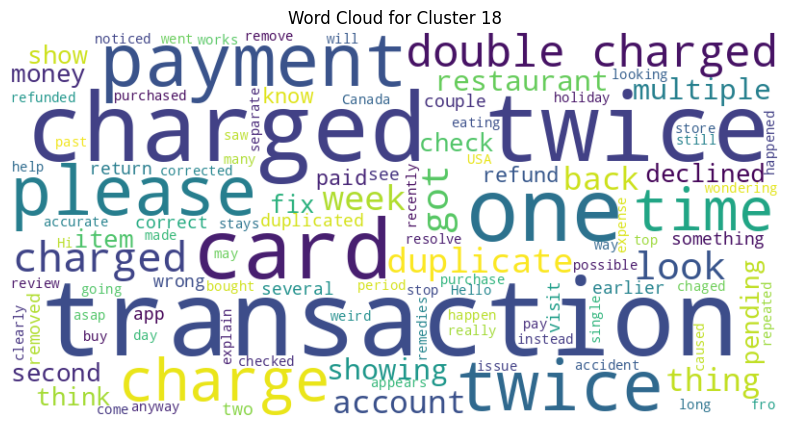

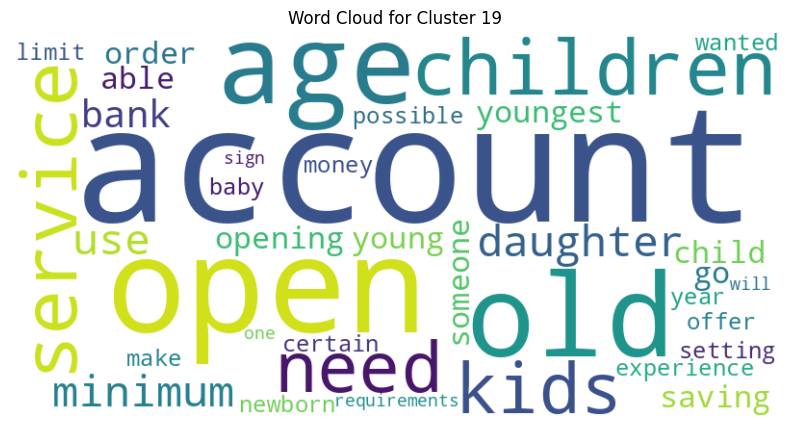

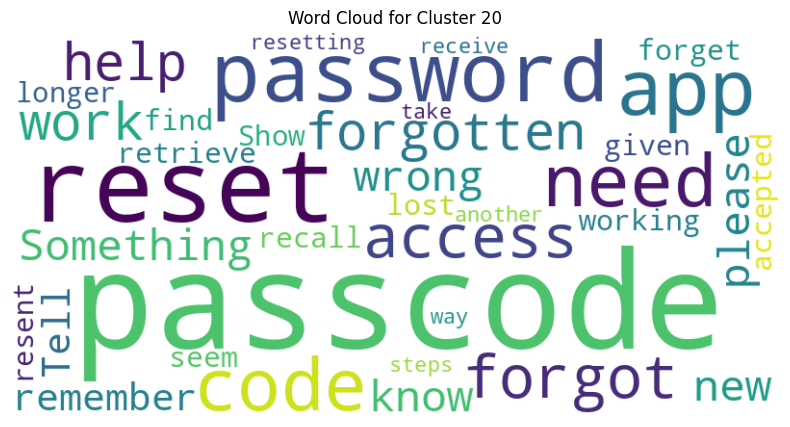

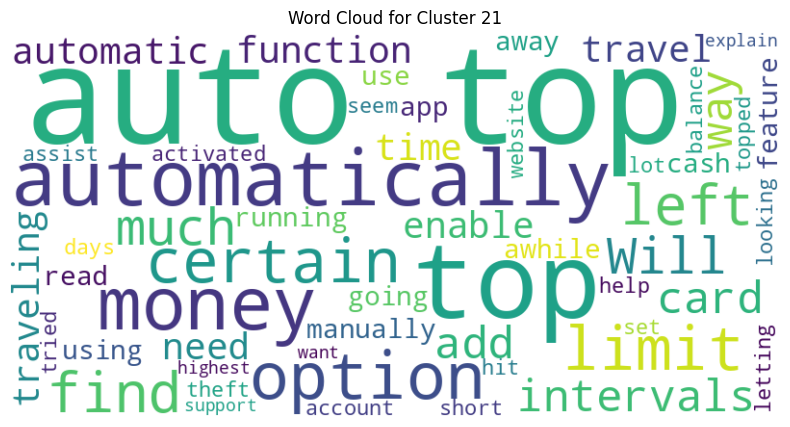

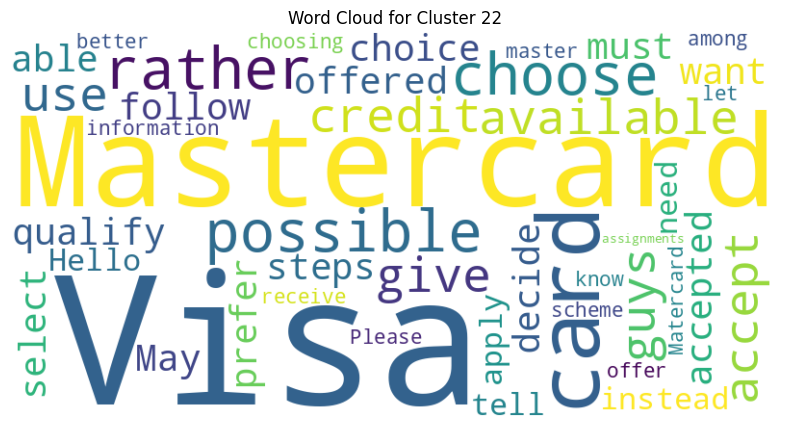

In [13]:
def generate_word_clouds(data, labels, num_clusters):
    for i in range(num_clusters):
        # Filter the data for the current cluster
        cluster_texts = data[data['cluster'] == i]['text']

        # Join all texts in the cluster into a single string
        cluster_text = ' '.join(cluster_texts)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cluster {i}')
        plt.show()

# Add the cluster labels to the DataFrame
test['cluster'] = labels

# Determine the number of clusters
num_clusters = len(set(labels))

# Generate word clouds for each cluster
generate_word_clouds(test, labels, num_clusters)


Louvain Hierarchy

In [14]:
louvain = LouvainHierarchy()
dendrogram = louvain.fit_predict(adjacency)
labels_5 = cut_straight(dendrogram, n_clusters=5)   # Coarsest level (fewest clusters)
labels_15 = cut_straight(dendrogram, n_clusters=15) # Intermediate level
labels_30 = cut_straight(dendrogram, n_clusters=30) # Finer level (more clusters)
print(labels_5)
print(labels_15)
print(labels_30)

[9 9 9 ... 4 4 4]
[9 9 9 ... 4 4 4]
[548 721 722 ...   9   9   9]


In [15]:
from sknetwork.hierarchy import cut_balanced
labels_balanced = cut_balanced(dendrogram)
labels_balanced

array([1188, 1579, 1580, ...,   19,   19,   19])

In [16]:
labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=5, return_dendrogram=True)
print(labels)

[9 9 9 ... 4 4 4]


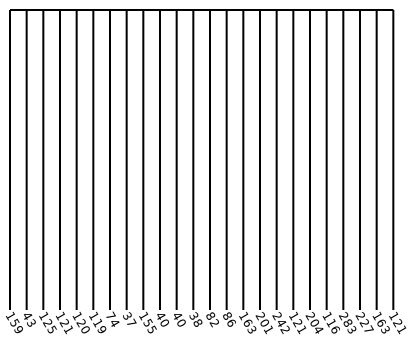

In [17]:
_, counts = np.unique(labels, return_counts=True)
image = svg_dendrogram(dendrogram_aggregate, names=counts, rotate_names=True)
SVG(image)

In [18]:
dasgupta_score(adjacency, dendrogram)

0.8888611909719023

In [33]:
test["topic_BERT_bank"] = louvain.fit_predict(adjacency)

In [34]:
BERT_bank_df = test.copy()
BERT_bank_df.rename(columns={'text': 'Utterance', 'category': 'Assigned label','topic_BERT_bank': 'Cluster'}, inplace=True)

In [35]:
cluster_info = {}

for i in range(num_clusters):
  cluster_df = BERT_bank_df[BERT_bank_df["Cluster"]== i]
  value_counts = cluster_df["Assigned label"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    if count > 6:
      category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{0: {'atm_support': 40,
  'wrong_exchange_rate_for_cash_withdrawal': 40,
  'declined_cash_withdrawal': 40,
  'card_payment_wrong_exchange_rate': 39,
  'exchange_rate': 39,
  'pending_cash_withdrawal': 39,
  'cash_withdrawal_charge': 39,
  'cash_withdrawal_not_recognised': 38,
  'card_swallowed': 37,
  'wrong_amount_of_cash_received': 7},
 1: {'pending_top_up': 40,
  'verify_top_up': 40,
  'top_up_limits': 39,
  'top_up_reverted': 38,
  'top_up_failed': 38,
  'topping_up_by_card': 37},
 2: {'top_up_by_bank_transfer_charge': 39,
  'top_up_by_card_charge': 39,
  'transfer_fee_charged': 38,
  'receiving_money': 37,
  'beneficiary_not_allowed': 35,
  'transfer_into_account': 35},
 3: {'declined_card_payment': 39,
  'pending_card_payment': 38,
  'reverted_card_payment?': 38,
  'failed_transfer': 38,
  'declined_transfer': 36},
 4: {'card_acceptance': 40,
  'country_support': 40,
  'getting_spare_card': 39,
  'order_physical_card': 37,
  'disposable_card_limits': 36},
 5: {'exchange_via_app':

In [63]:
from sklearn.metrics import silhouette_samples
BERT_bank_df['Cluster name'] = BERT_bank_df['Cluster'].map(cluster_info)
BERT_bank_df['Cluster name'] = BERT_bank_df['Cluster name'].apply(lambda x: list(x.keys())[0] if x else None)


In [64]:
outputs = []
for text in BERT_bank_df["Utterance"].tolist():
    outputs.append(classifier(text))

In [65]:
predicted_output = []
predicted_output_score = []

for output in outputs:
    # Check if 'output' is a list of dictionaries
    if isinstance(output, list) and all(isinstance(item, dict) for item in output):
        # Check if each dictionary has a 'score' key and it's a number
        if all('score' in item and isinstance(item['score'], (int, float)) for item in output):
            max_score_data = max(output, key=lambda d: d['score'])
            max_score = max_score_data['score']
            max_label = max_score_data['label']

            predicted_output.append(max_label)
            predicted_output_score.append(max_score)
        else:
            print("Warning: One or more dictionaries in the output do not have a numerical 'score' key.")
    else:
        print("Warning: Output is not a list of dictionaries.")

print(predicted_output)
print(predicted_output_score)

['card_arrival', 'card_arrival', 'card_arrival', 'card_delivery_estimate', 'card_arrival', 'card_delivery_estimate', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_delivery_estimate', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'lost_or_stolen_card', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_delivery_estimate', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_linking', 'card_li

In [66]:
BERT_bank_df['Predicted label'] = predicted_output
BERT_bank_df['Predicted confidence'] = predicted_output_score
sorted_column = ["Utterance", "Assigned label",	"Predicted label", "Predicted confidence", "Cluster",	"Cluster name"]
BERT_bank_df = BERT_bank_df[sorted_column]
BERT_bank_df

Utterance   Assigned label  \
0                              How do I locate my card?     card_arrival   
1     I still have not received my new card, I order...     card_arrival   
2     I ordered a card but it has not arrived. Help ...     card_arrival   
3      Is there a way to know when my card will arrive?     card_arrival   
4                          My card has not arrived yet.     card_arrival   
...                                                 ...              ...   
3075      If i'm not in the UK, can I still get a card?  country_support   
3076                 How many countries do you support?  country_support   
3077              What countries do you do business in?  country_support   
3078             What are the countries you operate in.  country_support   
3079         Can the card be mailed and used in Europe?  country_support   

             Predicted label  Predicted confidence  Cluster     Cluster name  
0               card_arrival              0.466479        9     card_arrival  
1               card_arrival              0.977467        9     card_arrival  
2               card_arrival              0.925289        9     card_arrival  
3     card_delivery_estimate              0.944849        9     card_arrival  
4               card_arrival              0.980883        9     card_arrival  
...                      ...                   ...      ...              ...  
3075         country_support              0.974657        4  card_acceptance  
3076         country_support              0.974706        4  card_acceptance  
3077         country_support              0.974942        4  card_acceptance  
3078         country_support              0.973756        4  card_acceptance  
3079         country_support              0.973107        4  card_acceptance  

[3080 rows x 6 columns]